## 导包

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta 

## 设置与读取

In [2]:
train_data = pd.read_csv('raw_data/train_public.csv')
submit_example = pd.read_csv('raw_data/submit_example.csv')
test_public = pd.read_csv('raw_data/test_public.csv')
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

## 模型模块

In [3]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [4]:

def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')

In [5]:
# train_data['earlies_credit_mon']

## 数据预处理

In [6]:
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])

#81后加 

# trti = set(train_data.title.unique())
# inte = trti.intersection( set(test_public.title.unique()) )

# train_data.loc[train_data.title.isin(inte)==False,'title'] = np.nan
# test_public.loc[test_public.title.isin(inte)==False,'title'] = np.nan


## 对抗过拟合-特征粒度处理

In [7]:
# debt_loan_ratio
# recircle_u
# recircle_b
# ------取值超过三千
# train_data['debt_loan_ratio'] = np.round(train_data['debt_loan_ratio'],1)
# train_data.loc[train_data['debt_loan_ratio']>=60,'debt_loan_ratio']=60
# test_public['debt_loan_ratio'] = np.round(test_public['debt_loan_ratio'],1)
# test_public.loc[test_public['debt_loan_ratio']>=60,'debt_loan_ratio']=60

# train_data['recircle_u'] = np.round(train_data['recircle_u'],1)
# test_public['recircle_u'] = np.round(test_public['recircle_u'],1)

# train_data['recircle_b'] = np.round(train_data['recircle_b'])
# test_public['recircle_b'] = np.round(test_public['recircle_b'])

In [8]:
# train_data['earliesCreditMon'] .isnull().sum()

## 时间特征

In [9]:
train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year



# train_data['issue_date_year'] = train_data['issue_date'].dt.year
# test_public['issue_date_year'] = test_public['issue_date'].dt.year



#81后加  单独加没用
# train_data['issue_date_toNow'] = (pd.to_datetime('2021-08-01') - train_data['issue_date']).dt.days
# test_public['issue_date_toNow'] = (pd.to_datetime('2021-09-01') - test_public['issue_date']).dt.days
# train_data['issue_year_2_CreMon'] = (train_data['issue_date'] - train_data['earlies_credit_mon']).dt.days
# test_public['issue_year_2_CreMon'] = (test_public['issue_date'] - test_public['earlies_credit_mon']).dt.days






## Pcode 特征

In [10]:
# #81后加 

# train_data['post_code_to_mean_interst'] = train_data.groupby(['post_code'])['interest'].transform('mean')
# test_public['post_code_to_mean_interst'] = test_public.groupby(['post_code'])['interest'].transform('mean')
# train_data['post_code_cnt'] = train_data['post_code'].map(train_data['post_code'].value_counts())
# train_data.loc[train_data['post_code_cnt']<=5,'post_code_to_mean_interst'] = np.nan
# del train_data['post_code_cnt']
# test_public['post_code_cnt'] = test_public['post_code'].map(test_public['post_code'].value_counts())
# test_public.loc[test_public['post_code_cnt']<=5,'post_code_to_mean_interst'] = np.nan
# del test_public['post_code_cnt']




## 精度处理，没有提升，不代表不对

In [11]:
# monthly_payment//10           
# recircle_b           
# train_data.loc[train_data.recircle_b==0,'recircle_b']=-1
# train_data.recircle_b = train_data.recircle_b//100


# ------代码
# early_return_amount//10      
# early_return_amount_3mon //10

# train_data['monthly_payment'] = train_data['monthly_payment']//10
# test_public['monthly_payment'] = test_public['monthly_payment']//10

# train_data['early_return_amount'] = train_data['early_return_amount']//10
# test_public['early_return_amount'] = test_public['early_return_amount']//10

# train_data['early_return_amount_3mon'] = train_data['early_return_amount_3mon']//10
# test_public['early_return_amount_3mon'] = test_public['early_return_amount_3mon']//10

# train_data.loc[train_data.recircle_b==0,'recircle_b']=-1
# train_data.recircle_b = train_data.recircle_b//100

# test_public.loc[test_public.recircle_b==0,'recircle_b']=-1
# test_public['recircle_b'] = test_public['recircle_b']//100

## 精度处理后添加特征

In [12]:
# train_data['post_code_cnt'] = train_data['post_code'].map(train_data['post_code'].value_counts())
# test_public['post_code_cnt'] = test_public['post_code'].map(test_public['post_code'].value_counts())

# for col in ['monthly_payment','early_return_amount','early_return_amount_3mon']:
#     for sta in ['mean','std']:
#         train_data['Pcode_{}_to_{}'.format(sta,col)] = train_data.groupby(['post_code'])[col].transform(sta)
#         test_public['Pcode_{}_to_{}'.format(sta,col)] = test_public.groupby(['post_code'])[col].transform(sta)
#         test_public.loc[test_public['post_code_cnt']<=5,'Pcode_{}_to_{}'.format(sta,col)] = np.nan
#         train_data.loc[train_data['post_code_cnt']<=5,'Pcode_{}_to_{}'.format(sta,col)] = np.nan


# del train_data['post_code_cnt']
# del test_public['post_code_cnt']


## 自然编码

In [13]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
# 'f1','policy_code','app_type' 这三个去掉是881
col_to_drop = ['issue_date', 'earlies_credit_mon','f1','policy_code','app_type']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 ) 
# data = pd.concat( [train_data,test_public] )


#81后加 
# for col in cat_cols:
#     dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
#     data = pd.concat([data, dum], axis=1)
# #     del data[col]
#     del dum



## 模型与输出

In [14]:
# train = data[data['isDefault'].notna()]
# test  = data[data['isDefault'].isna()]

# del data
# y = train['isDefault']

# del train_data,test_public


y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train_data, test_public, y, folds)

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.914423	training's binary_logloss: 0.286097	valid_1's auc: 0.890731	valid_1's binary_logloss: 0.306099
Fold  1 AUC : 0.890731
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[15]	training's auc: 0.907653	training's binary_logloss: 0.314684	valid_1's auc: 0.889965	valid_1's binary_logloss: 0.318763
Fold  2 AUC : 0.889965
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.957514	training's binary_logloss: 0.218137	valid_1's auc: 0.876234	valid_1's binary_logloss: 0.309997
Early stopping, best iteration is:
[75]	training's auc: 0.948736	training's binary_logloss: 0.229992	valid_1's auc: 0.877364	valid_1's binary_logloss: 0.308711
Fold  3 AUC : 0.877364
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[40]	training's auc: 0.929763	training's binar

In [15]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('submit/tmpSub.csv', index=False)

In [16]:
# train.issue_date_year.value_counts()

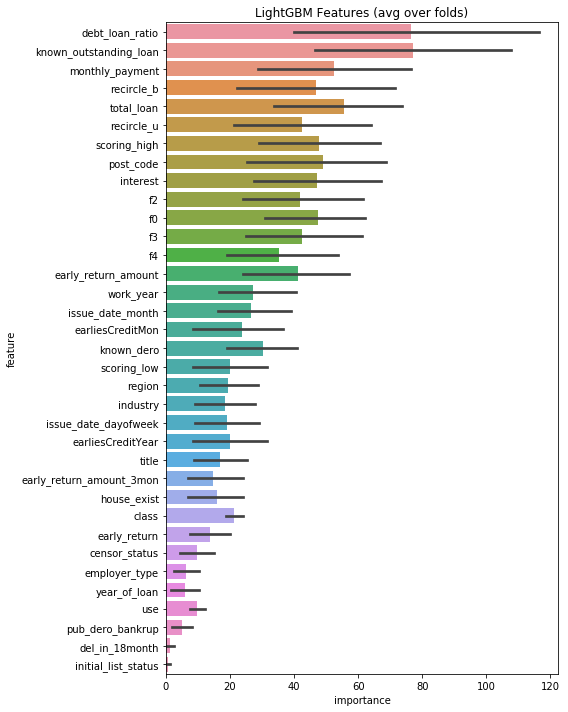

In [17]:
display_importances(importances)

# 处理一些取值精度后没有大的变化 依然是状态 / 得分
# 0.88142741347 

In [18]:
# train.nunique()